In [1]:
path="fashion_data/"

import gzip
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

label_file=gzip.open(path + 'train-labels-idx1-ubyte.gz')
y_train= np.frombuffer(label_file.read(), dtype=np.uint8, offset=8)

image_file=gzip.open(path + 'train-images-idx3-ubyte.gz', 'rb')
x_train= np.frombuffer(image_file.read(), dtype=np.uint8, offset=16).reshape(len(y_train), 784)

valid_label_file=gzip.open(path + 't10k-labels-idx1-ubyte.gz')
y_valid= np.frombuffer(valid_label_file.read(), dtype=np.uint8, offset=8)

valid_image_file=gzip.open(path + 't10k-images-idx3-ubyte.gz', 'rb')
x_valid= np.frombuffer(valid_image_file.read(), dtype=np.uint8, offset=16).reshape(len(y_valid), 784)

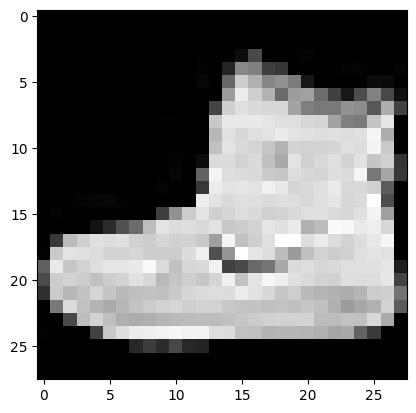

In [2]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [3]:
y_train[0]

9

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

In [4]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_valid, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_valid, dtype=torch.long)

In [5]:
class MySimpleNN(torch.nn.Module):

    def __init__(self):
        super(MySimpleNN, self).__init__()

        self.fc1 = torch.nn.Linear(784, 300)
        self.fc2 = torch.nn.Linear(300, 100)
        self.fc3 = torch.nn.Linear(100, 10)

        self.bn1 = torch.nn.BatchNorm1d(300)
        self.bn2 = torch.nn.BatchNorm1d(100)

    def forward(self, xb):
        z2 = self.fc1(xb)
        a2 = torch.relu(z2)
        a2_bn = self.bn1(a2)

        z3 = self.fc2(a2_bn)
        a3 = torch.relu(z3)
        a3_bn = self.bn2(a3)

        y_hat = self.fc3(a3_bn)

        return y_hat

In [6]:
def get_batch(x, y, batch_size):
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size], y[i:i+batch_size]

In [7]:
model = MySimpleNN()
xb, yb = next(get_batch(x_train, y_train, 64))
model(xb).shape

torch.Size([64, 10])

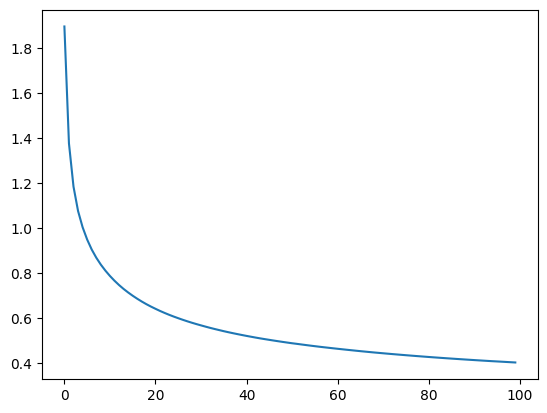

In [8]:
model = MySimpleNN()
lr=0.0001

batch_size=128

loss_fn = nn.CrossEntropyLoss()

def train(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
        model.zero_grad()
    return loss.item()

losses = []
batch_count=len(x_train)//batch_size

for epoch in range(100):
    loss_sum = 0

    for xb, yb in get_batch(x_train, y_train, batch_size):
        loss_sum += train(xb, yb)
    losses.append(loss_sum/batch_count)

plt.plot(losses)

In [9]:
xb_test, yb_test = next(get_batch(x_test, y_test, 64))
preds = model(xb_test)
preds.shape

torch.Size([64, 10])

In [10]:
preds[0]

tensor([-1.4767, -0.8050, -2.4055, -1.8607, -1.4755,  2.9744, -2.4426,  1.7735,
        -1.1051,  4.3270], grad_fn=<SelectBackward0>)

In [11]:
torch.argmax(preds[0])

tensor(9)

In [12]:
yb_test[0]

tensor(9)

In [13]:
preds = model(x_test)
preds = torch.argmax(preds, dim=1)

In [14]:
correct=0
for i in range(len(preds)):
    if preds[i] == y_valid[i]:
        correct += 1

print(correct, "von ", len(x_valid), "korrekt vorhergesagt.")

8512 von  10000 korrekt vorhergesagt.
